## 통계 기반의 단어 표현

In [4]:
word2id={}
id2word={}

text=words="You say goodbye and i say hello"

for i,word in enumerate(words):
    
    print(f"{i}, {word}")

    new_id=len(word2id)
    word2id[word]=new_id
    id2word[new_id]=word

0, Y
1, o
2, u
3,  
4, s
5, a
6, y
7,  
8, g
9, o
10, o
11, d
12, b
13, y
14, e
15,  
16, a
17, n
18, d
19,  
20, i
21,  
22, s
23, a
24, y
25,  
26, h
27, e
28, l
29, l
30, o


In [2]:
from pprint import pprint

# Pretty-print word2id
pprint(word2id)

# Pretty-print id2word
pprint(id2word)


{' ': 13,
 'Y': 0,
 'a': 13,
 'b': 9,
 'd': 12,
 'e': 14,
 'g': 7,
 'h': 13,
 'i': 12,
 'l': 15,
 'n': 11,
 'o': 15,
 's': 13,
 'u': 2,
 'y': 13}
{0: 'Y',
 1: 'o',
 2: 'u',
 3: ' ',
 4: 's',
 5: 'a',
 6: 'y',
 7: 'g',
 8: 'd',
 9: 'b',
 10: 'e',
 11: 'n',
 12: 'i',
 13: 'h',
 14: 'l',
 15: 'o'}


## corpus==하나의 문장 집합

In [5]:
import numpy as np
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [6]:
preprocess(text)

(array([0, 1, 2, 3, 4, 1, 5]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'})

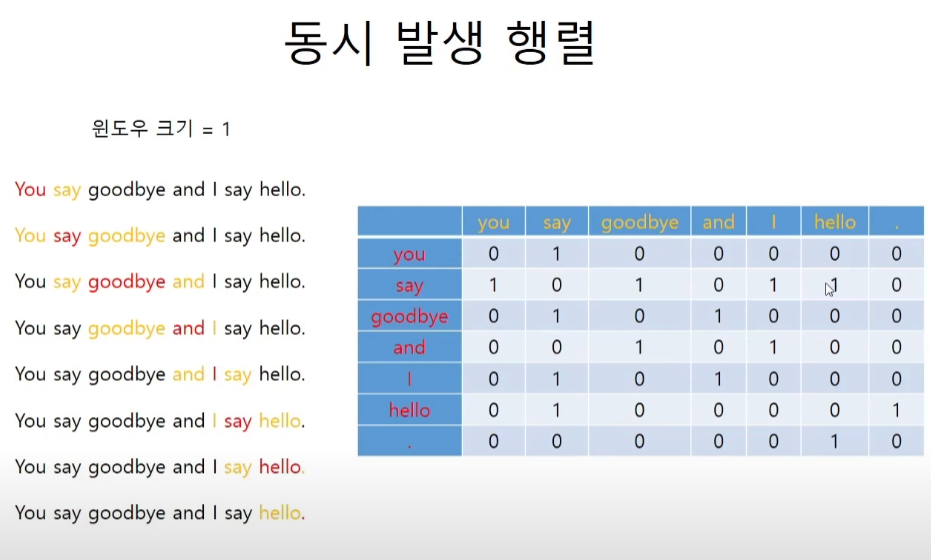

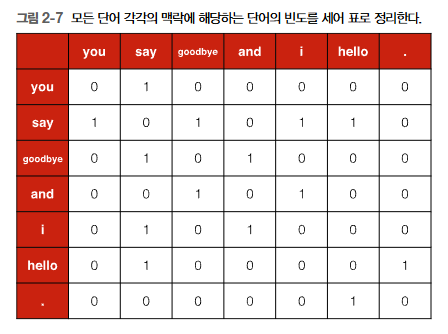

In [7]:
import numpy as np 

def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        # print(f"{idx}th {id2word[word_id]}")
        
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0: # 위치에 이웃이 존재하면
                
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1 # 단어 순서가 행을 대처함

            if right_idx < corpus_size: # 위치에 이웃이 존재하면
                
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

            # print(i,co_matrix,"\n")
    
    return co_matrix


In [8]:
text = 'you say goodbye and I say hello.'
corpus, wi, iw = preprocess(text)

In [14]:
wi

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [15]:
len(wi)

7

In [16]:
matrix = create_co_matrix(corpus, vocab_size=len(wi), window_size=1)
print(matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


## 코사인 유사도

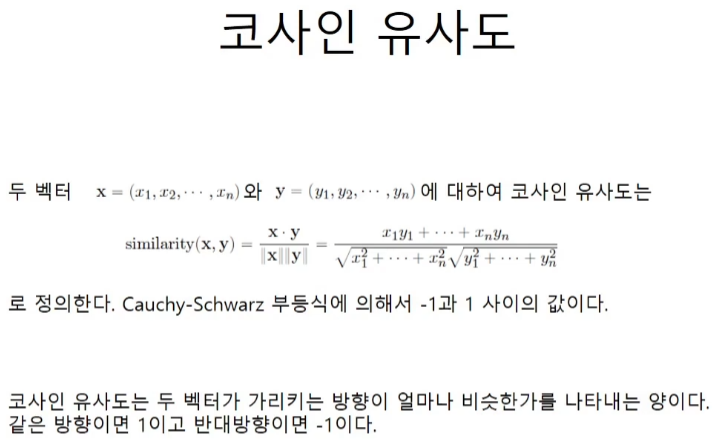
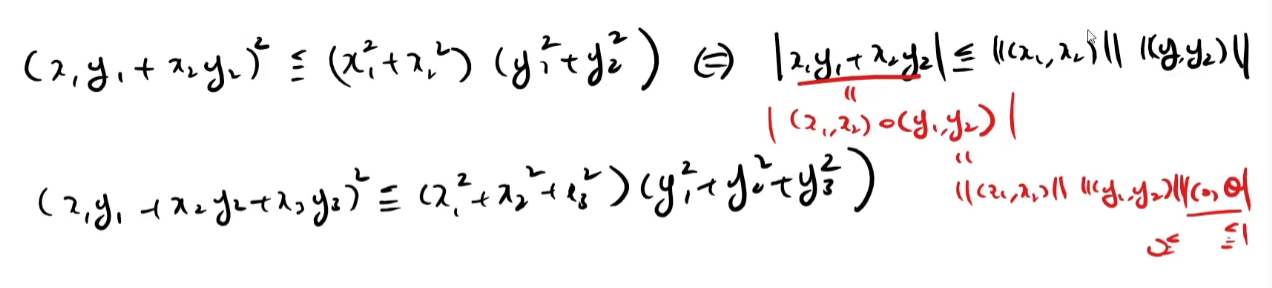

In [17]:
def cos_similarity(x, y, eps=1e8-8):
    '''
    x : 벡터
    y : 벡터
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [19]:
# coding: utf-8
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
C



array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

In [20]:
c0 = C[word_to_id['you']]  # "you"의 단어 벡터  word_to_id['you']는 행 번호
c1 = C[word_to_id['i']]    # "i"의 단어 벡터
print(cos_similarity(c0, c1))

0.7071067691154799


In [21]:
c0,c1

(array([0, 1, 0, 0, 0, 0, 0]), array([0, 1, 0, 1, 0, 0, 0]))

In [22]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [23]:
# coding: utf-8
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)



[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## Mutual Information

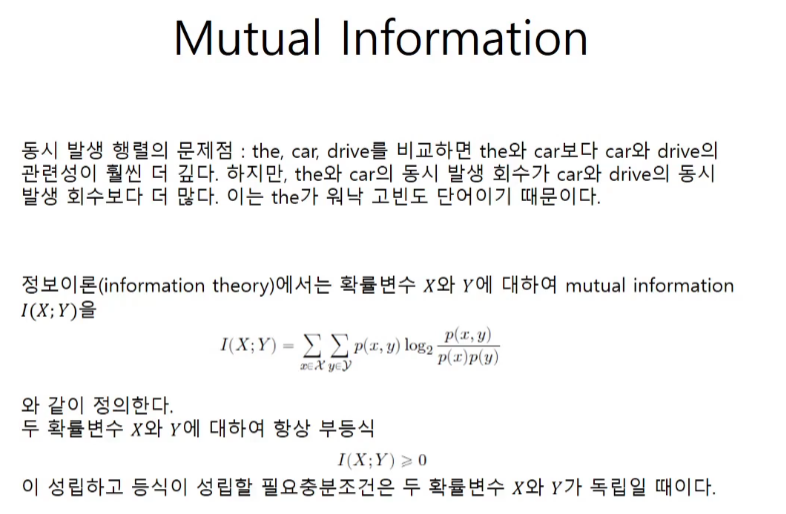
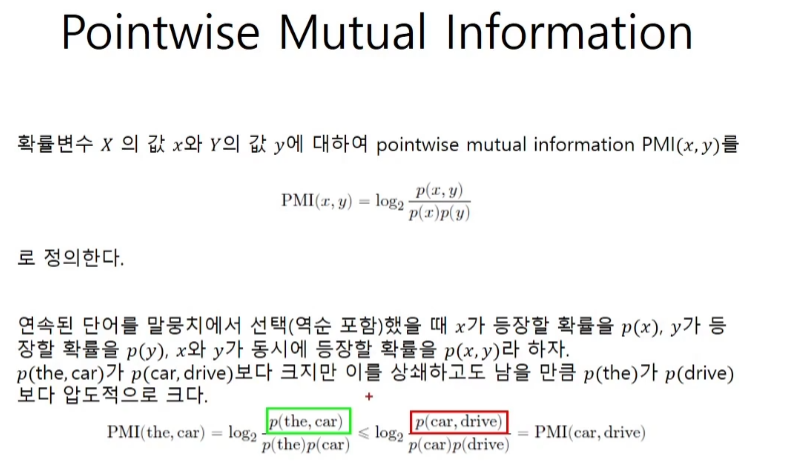
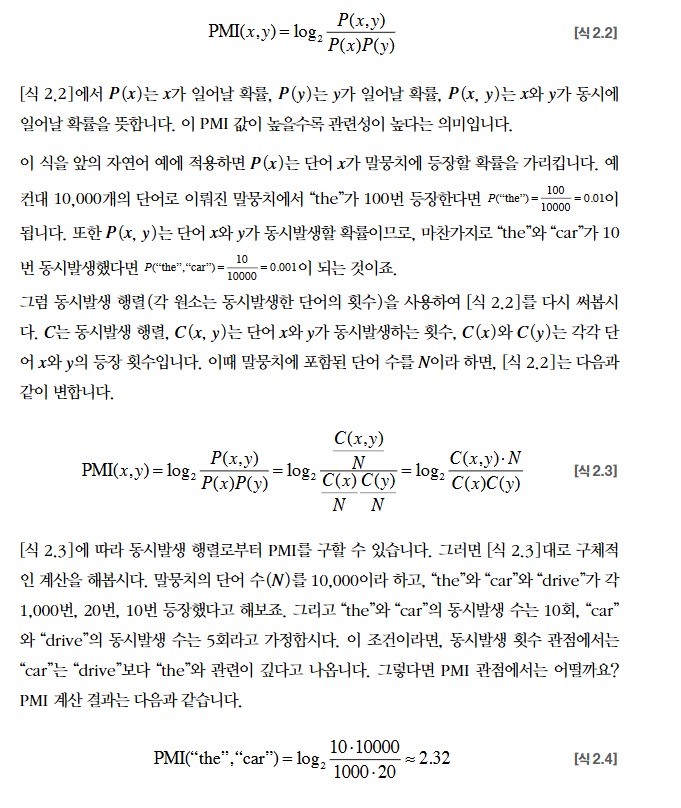
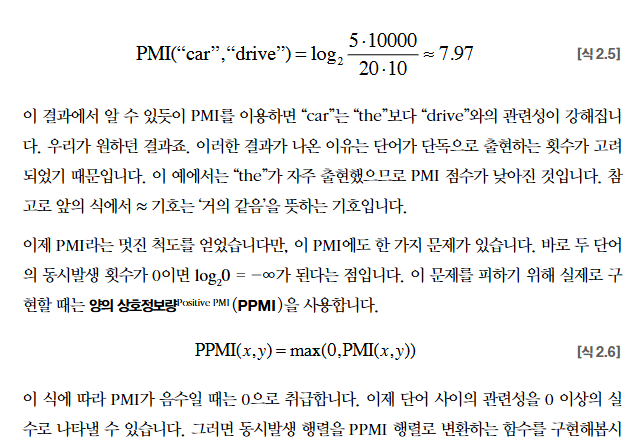

In [24]:
C,np.sum(C),np.sum(C, axis=0)

(array([[0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0]]),
 14,
 array([1, 4, 2, 2, 2, 2, 1]))

In [25]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''
    C : 동시발생행렬
    verbose : 진행상황
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C) # 모두 더하기 14
    S = np.sum(C, axis=0) # 각 행으로 더하기  array([1, 4, 2, 2, 2, 2, 1]))
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[i]*S[j]) + eps)
            
            #print(f"{j},{S[i]*S[j]}","\n")
            
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print(f"{100*cnt/total} 완료")
    return M

In [26]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)



동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


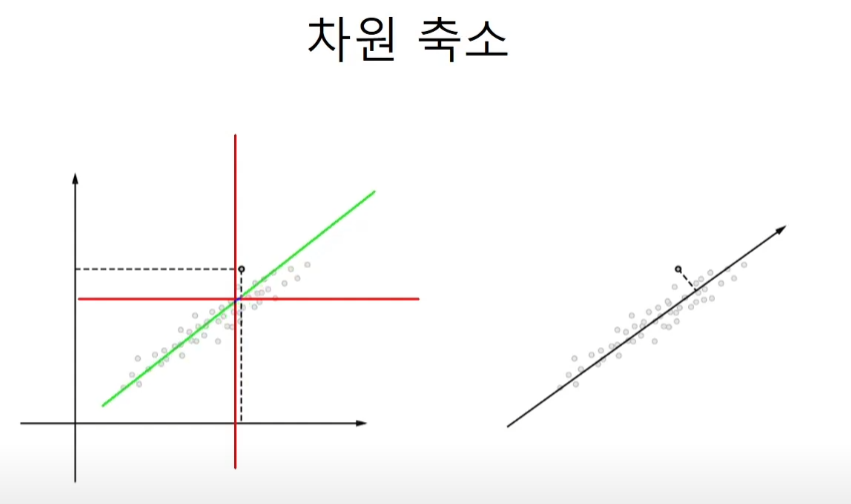
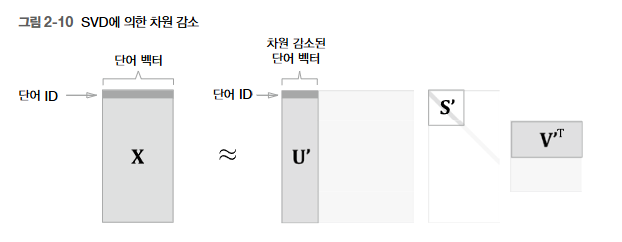
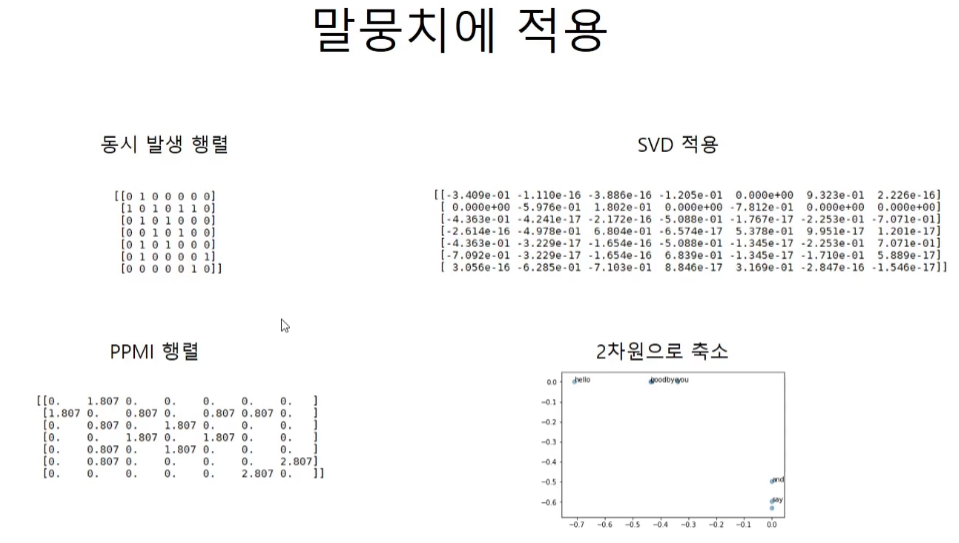

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-1.110e-16  3.409e-01 -1.205e-01 -3.886e-16  0.000e+00 -9.323e-01
  8.768e-17]


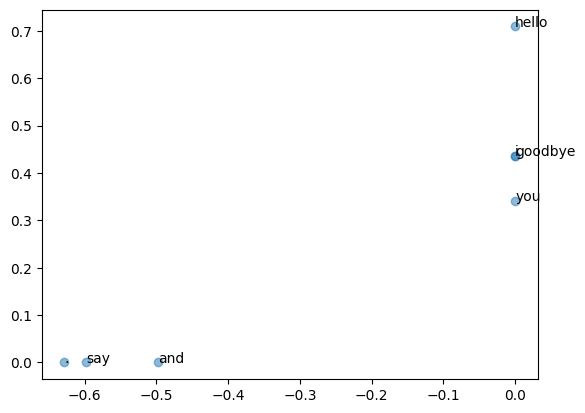

In [16]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print(C[0])
print(W[0])
print(U[0])

# 플롯
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()


In [27]:
print('말뭉치 크기:', len(corpus))

말뭉치 크기: 8


In [17]:
# coding: utf-8
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])


말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [17]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


동시발생 수 계산 ...
PPMI 계산 ...


c:\study\04_NLP\special_part\common\util.py:141: RuntimeWarning: overflow encountered in scalar multiply
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
c:\study\04_NLP\special_part\common\util.py:141: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료


KeyboardInterrupt: 

In [ ]:
[query] you
 i: 0.6597464084625244
 we: 0.5626571178436279
 else: 0.534852921962738
 do: 0.5244743824005127
 'll: 0.5175811052322388

[query] year
 quarter: 0.6652063131332397
 month: 0.6513795256614685
 last: 0.6350002288818359
 week: 0.6250417828559875
 third: 0.5998818874359131

[query] car
 luxury: 0.6504465341567993
 cars: 0.5932006239891052
 auto: 0.5872380137443542
 vehicle: 0.5556439757347107
 truck: 0.5054734945297241

[query] toyota
 motor: 0.6902073621749878
 mazda: 0.6336458921432495
 motors: 0.6244127750396729
 lexus: 0.6123119592666626
 honda: 0.597798228263855


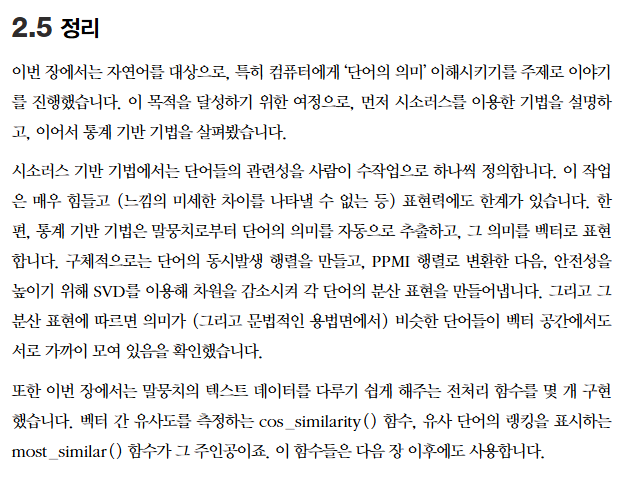